In [50]:
import findspark
findspark.init()

from pyspark import SparkContext
from pyspark.mllib.clustering import KMeans
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
import seaborn as sns
sns.set(font_scale=1.5)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

#Let's start Spark and read our csv file, I got the csv file from https://data.cityofnewyork.us
sc = SparkContext(appName = "traffic")
lines = sc.textFile('NYC_accidents_clean.csv')

#There are supposed to be 28 columns, so let's filter the other rows
lines = lines.filter(lambda x: len(x.split(',')) == 28)
print lines.take(1)

[u'10/21/2018,0:00,BROOKLYN,11214,40.59039,-73.99155,26 AVENUE                       ,CROPSEY AVENUE,,0,0,0,0,0,0,0,0,Unspecified,,,,,4004212,Station Wagon/Sport Utility Vehicle,,,,']


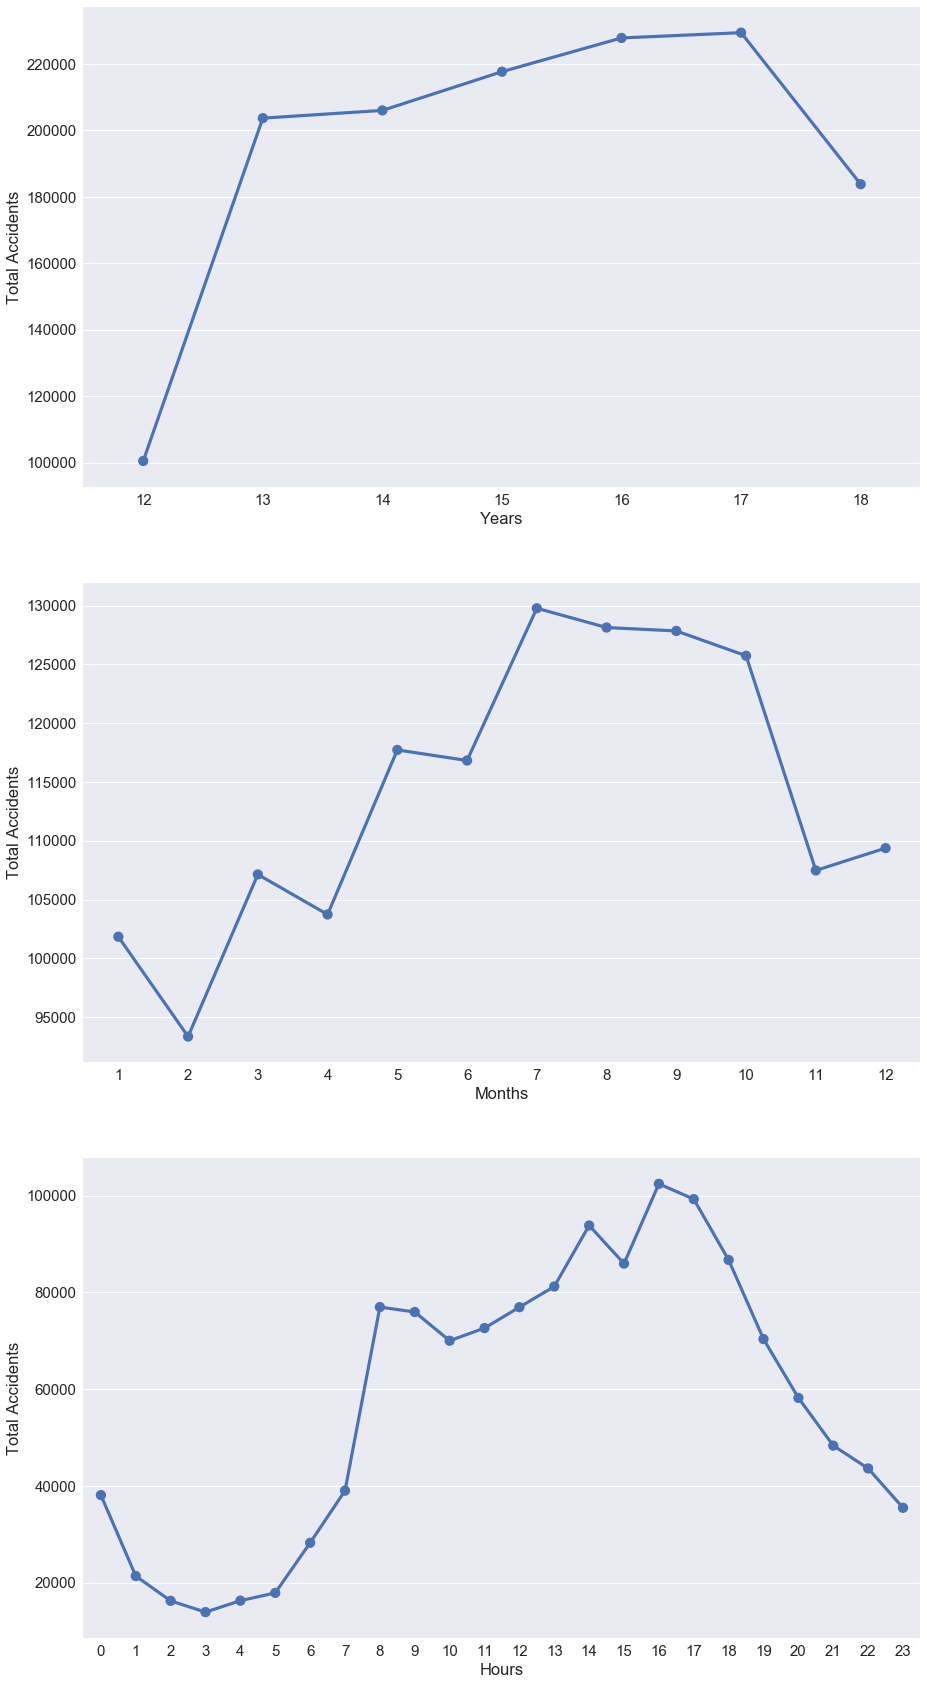

In [32]:
#Let's group the number of accidents based on the year, month and time of the day
yearAccident = lines.map(lambda x: (x.split(',')[0][-2:],1))
totYearAccident = yearAccident.reduceByKey(lambda x,y: x+y).collect()
year1, yearAcc = zip(*totYearAccident)

monthAccident = lines.map(lambda x: (x.split(',')[0][:2],1))
totMonthAccident = monthAccident.reduceByKey(lambda x,y: x+y).collect()
year2, monthAcc = zip(*totMonthAccident)

hourAccident = lines.filter(lambda x: len(x.split(',')[1]) == 4 and len(x.split(',')[1]) == 5)
hourAccident = hourAccident.map(lambda x: (x.split(',')[1][0],1) if x.split(',')[1][1] == ':' else (x.split(',')[1][:2],1))
totHourAccident = hourAccident.reduceByKey(lambda x,y: x+y).collect()
year3, hourAcc = zip(*totHourAccident)

#A few plots showing the trends of accidents
fig,axes= plt.subplots(3,1,figsize=(15,30))
ax = sns.pointplot(y = map(int,yearAcc), x = map(int,year1), join=True, ax = axes[0])
ax.set(ylabel="Total Accidents", xlabel="Years")
ax = sns.pointplot(y = map(int,monthAcc), x = map(int,year2), join=True, ax = axes[1])
ax.set(ylabel="Total Accidents", xlabel="Months")
ax = sns.pointplot(y = map(int,hourAcc), x = map(int,year3), join=True, ax = axes[2])
ax.set(ylabel="Total Accidents", xlabel="Hours")
plt.show()

In [9]:
#Clearly, accidents peak around rush hours and there is an interesting seasonal trend
#More accidents are happening in the summer months(probably because of increasing pedestarian presence on the streets)
#Now another question rises; what is the top reason of the accidents? Is it pedestarians or cars?
#Let's look at the relative numbers of fatalities(deaths) in between cars, cyclists and pedestarians
motoristFatalities = lines.map(lambda x: int(x.split(',')[16]))
totmotoristFatalities = motoristFatalities.reduce(lambda x,y: x+y)

cyclistFatalities = lines.map(lambda x: int(x.split(',')[14]))
totcyclistFatalities = cyclistFatalities.reduce(lambda x,y: x+y)

pedFatalities = lines.map(lambda x: int(x.split(',')[12]))
totpedFatalities = pedFatalities.reduce(lambda x,y: x+y)

print 'Deaths involving a motorist:', totmotoristFatalities
print 'Deaths involving a cyclist:', totcyclistFatalities
print 'Deaths involving a pedestarian:', totpedFatalities

 Deaths involving a motorist: 622
Deaths involving a cyclist: 110
Deaths involving a pedestarian: 869


In [26]:
#Finally let's compare the reasons for these accidents based on the year of the accident
def mapReducer(lines, colNum):
    mapper = lines.map(lambda x: ((x.split(',')[0][-2:],x.split(',')[colNum]),1))
    reducer = mapper.reduceByKey(lambda x,y: x+y).collect()
    return mapper, reducer

reasonv1, totReasonv1 = mapReducer(lines, 17)
reasonv2, totReasonv2 = mapReducer(lines, 18)
reasonv3, totReasonv3 = mapReducer(lines, 19)
reasonv4, totReasonv4 = mapReducer(lines, 20)
reasonv5, totReasonv5 = mapReducer(lines, 21)

reason = reasonv1.union(reasonv2)
reason = reason.union(reasonv3)
reason = reason.union(reasonv4)
reason = reason.union(reasonv5)
totReason = reason.reduceByKey(lambda x,y: x+y).collect()
sortedByFrequencyOfReason = sorted(totReason, key=lambda x: x[1],reverse=True)

#Besides the unspecified accident reasons, let's look at the top accident reasons
reasonOfAccidents, NumberOfAccidents = zip(*sortedByFrequencyOfReason)
years, reasonOfAccident = zip(*reasonOfAccidents[14:20])
print map(str,reasonOfAccident)

['Driver Inattention/Distraction', 'Driver Inattention/Distraction', 'Driver Inattention/Distraction', 'Driver Inattention/Distraction', 'Driver Inattention/Distraction', 'Driver Inattention/Distraction']


[17, 18, 16, 15, 14, 13]


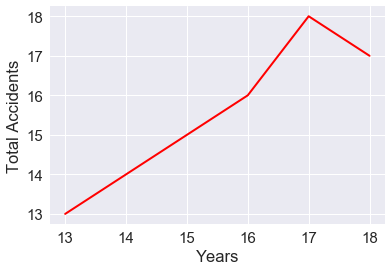

In [42]:
#Here is the plot of the trend of distraction over years resulting in accidents
#But before plotting lets sort the years in increasing order and order the corresponding number of accidents accordingly
Z = [x for _,x in sorted(zip(map(int,NumberOfAccidents[14:20]),map(int,years)))]
plt.figure()
plt.plot(sorted(map(int,years)),Z,'r-',markersize=10,linewidth=2, label='Driver Inattention/Distraction')
plt.ylabel('Total Accidents')
plt.xlabel('Years')
print map(int,years)
plt.show()

In [45]:
#Probably because of the increasing social media usage, distraction results in more and more accidents over the years
#ps. 2018 data is until October 25th
#Now let's cluster the locations of the accidents but befero that we need to do more cleaning on the data
lines = lines.filter(lambda x: len(x.split(',')[4]) > 0 and len(x.split(',')[5]) > 0)
lines = lines.filter(lambda x: float(x.split(',')[4].encode('utf8')) > 35 and float(x.split(',')[4].encode('utf8')) < 45)
lines = lines.filter(lambda x: float(x.split(',')[5].encode('utf8')) > -80 and float(x.split(',')[5].encode('utf8')) < -70)
location = lines.map(lambda x: [float(x.split(',')[4].encode('utf8')),float(x.split(',')[5].encode('utf8'))])

# After cleaning the data, we need to try a few number of centroids and look at the error associated with
#each of these number of centroids
#When the change in error is less than 5%(you can set this to another value), we can start our algorithm 
#with that many number of centroids
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return  (sum([x**2 for x in (np.asarray(point) - np.asarray(center))]))**0.5

error_list=[]
k = [5, 10, 15, 20, 25, 30, 35]
for i in k:
    clusters = KMeans.train(location, i, maxIterations=20,runs=20, initializationMode="random")
    WSSSE = location.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    error_list.append(WSSSE)

for i in range(7):
    print 'k=', k[i], "and error=", error_list[i]


k= 5 and error= 51825.3510534
k= 10 and error= 37883.2203628
k= 15 and error= 28846.4898034
k= 20 and error= 25517.1054331
k= 25 and error= 21665.8387103
k= 30 and error= 20133.6181095
k= 35 and error= 18471.1564582


In [47]:
#Let's choose the optimal k as 20
k_optimal = 20
clusters = KMeans.train(location, k_optimal, maxIterations=30,runs=30, initializationMode="random")

centersOfAccidents = []
for i in range(0,k_optimal):
    centeroid = clusters.centers[i]
    centersOfAccidents.append(centeroid)
print centersOfAccidents

[array([ 40.76218623, -73.8177269 ]), array([ 40.86503688, -73.9009697 ]), array([ 40.62567659, -74.02263792]), array([ 40.73853325, -73.86946664]), array([ 40.79424153, -73.95131987]), array([ 40.67292859, -73.97822552]), array([ 40.82787016, -73.92436743]), array([ 40.87850068, -73.84991382]), array([ 40.69845672, -73.94122445]), array([ 40.6938787 , -73.82192393]), array([ 40.61018988, -73.95653616]), array([ 40.72264537, -73.99675342]), array([ 40.59565722, -73.78367712]), array([ 40.58463106, -74.14236865]), array([ 40.750725 , -73.9188254]), array([ 40.67868642, -73.7589381 ]), array([ 40.83260795, -73.86233937]), array([ 40.74016134, -73.74918195]), array([ 40.66327257, -73.90218626]), array([ 40.75728771, -73.9802182 ])]


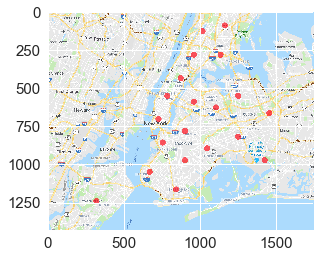

In [51]:
#We found all the centroids, I plotted them in google maps and here is how they look like
img=mpimg.imread('/Users/emre/accident_clusters.png')
imgplot = plt.imshow(img)

In [53]:
##Now let's try to predict the occurence of accidents with our data
##We'll use logistic regression for this problem, first we need to prepare the data by creating labeled points
lines = lines.filter(lambda x: len(x.split(',')[4]) > 0 and len(x.split(',')[5]) > 0)
linesAcc = lines.map(lambda x: (x.split(',')[0],(x.split(',')[10],x.split(',')[1],x.split(',')[4],x.split(',')[5])))

#The features we'll consider is the longitude and lattitude information, 
#precipitation information on a given day(for this, I'm going to combine the current dataset with another dataset),
#hour of the day and month of the year(as we saw clear trends previously based on these features)
#I preprocessed the weather data that I got from https://www.wunderground.com
linesW = sc.textFile('weather.csv')
linesW = linesW.map(lambda x: (x.split(',')[2],x.split(',')[1]))
lines = linesW.join(linesAcc)


In [56]:
#Here is how I normalized the features, I tried an average longitude and an average lattitude
#(other complicated normalization would be fine but this simple way worked the best)
def parseData(line):
    month = int(line[0][0:2])/12.0
    lat = float(line[1][1][2]) - 40
    lng = float(line[1][1][3]) + 75
    weather = float(line[1][0])
    
    if len(line[1][1][1][0:2])==5:
        time = int(line[1][1][1][0:2])/24.0
    else:
        time = int(line[1][1][1][0:1])/24.0
    
    if int(line[1][1][0])>0:
        label = 1
    else:
        label = 0
    
    features = [weather, lat, lng, time, month]

    return LabeledPoint(label,features)

parsedData = lines.map(parseData)

#We'll divide the training and test sets as 70 to 30%
training , test = parsedData.randomSplit([ 0.7 , 0.3] , seed = 11L)
model = LogisticRegressionWithLBFGS.train(training)

# Finally, evaluating the model on training data and test data separately
labelsAndPreds = training.map(lambda p: (p.label, model.predict(p.features)))
trainErr = labelsAndPreds.filter(lambda lp: lp[0] != lp[1]).count() / float(training.count())

print "Training Error = " + str(trainErr)

labelsAndPreds = test.map(lambda p: (p.label, model.predict(p.features)))
testErr = labelsAndPreds.filter(lambda lp: lp[0] != lp[1]).count() / float(test.count())
print "Training Error = " + str(testErr)


Training Error = 0.0010810793393
Training Error = 0.00109832872866


In [ ]:
sc.stop()